# Standard Precipitaion Index - N (SPI-N)

This notebook implements the SPI for multiple time scales. It's common to refer to SPI in terms of months accumulated, for example SPI-2 for 2 months, SPI-3 for 3 months, and so on. 

The SPI-N, must be calculated for every month, regardless the N value. The calculation will be simply:<br>
<b>` (Rain_m - Avg_m) / Std_m`, where  </b>

The `m` indicates the month considered. So the `Avg_m` and `Std_m` can be precalculated for the 12 months, in advance. After that, even if we are calculating the SPI_m for for hundreds of months, the calculation will be pretty straightforward. 

The `Avg_m` for 1 month time scale is aready pre-calculated in the `MONTHLY_ACCUMULATED` data type. So, we need to pre-calculate the `Avg_m_N`, where N stands for the number os months (looking backwards). For example: 

`Avg_Sep_3` is the average for September, considering 3 months, so we need to accumulate July, August and September to retrieve their mean, and their standar deviation, considering all the years. We have to keep in mind that, when calculating `Avg_Jan_3`, we have to consider November and December from the previous year. 

With all those considerations in mind, let's try to pre-calculate `MONTHLY_AVERAGE_N` and `MONTHLY_STD_N`. 

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import logging
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

import xarray as xr
import geopandas as gpd

from mergedownloader.file_downloader import FileDownloader, ConnectionType
from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import *
from mergedownloader.utils import DateProcessor, DateFrequency

In [72]:
fd = FileDownloader(INPE_SERVER, connection_type=ConnectionType.HTTP)

Using wget through HTTP on: ftp.cptec.inpe.br


In [73]:
downloader = Downloader(
    file_downloader=fd,
    parsers=InpeParsers,
    local_folder='/workspaces/reports_folder/downloads2/',
    log_level=logging.DEBUG
)

In [74]:
InpeParsers

{<InpeTypes.DAILY_RAIN: 1>: Instance of DailyParser,
 <InpeTypes.MONTHLY_ACCUM_YEARLY: 2>: Instance of MonthlyAccumYearlyParser,
 <InpeTypes.DAILY_AVERAGE: 3>: Instance of DailyAverageParser,
 <InpeTypes.MONTHLY_ACCUM: 4>: Instance of MonthlyAccumParser,
 <InpeTypes.MONTHLY_ACCUM_MANUAL: 5>: Instance of MonthlyAccumManual,
 <InpeTypes.YEARLY_ACCUM: 6>: Instance of YearAccumulatedParser,
 <InpeTypes.MONTHLY_SP1: 10>: Instance of SPI1Processor,
 <InpeTypes.MONTHLY_AVG_N: 8>: Instance of MonthlyAvgNParser,
 <InpeTypes.MONTHLY_STD_N: 9>: Instance of MonthlyStdNParser,
 <InpeTypes.MONTHLY_SPI: 11>: Instance of SPIProcessor}

## Test: `SPIProcessor` class

In [76]:
spi = downloader.open_file('2024-08', InpeTypes.MONTHLY_SPI, n=12)

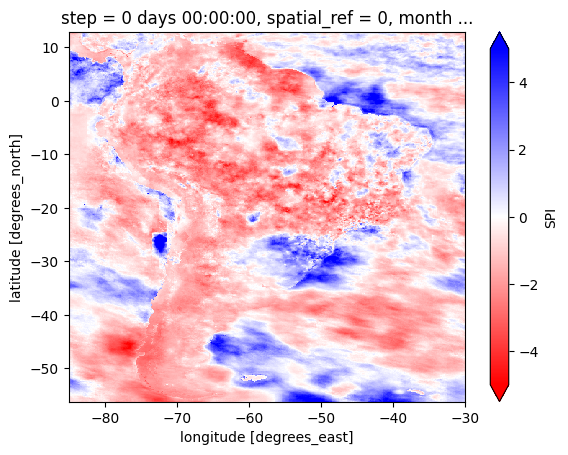

In [77]:
spi.plot(cmap='bwr_r', vmin=-5, vmax=5)

## Map Animation SPI-9

<Axes: >

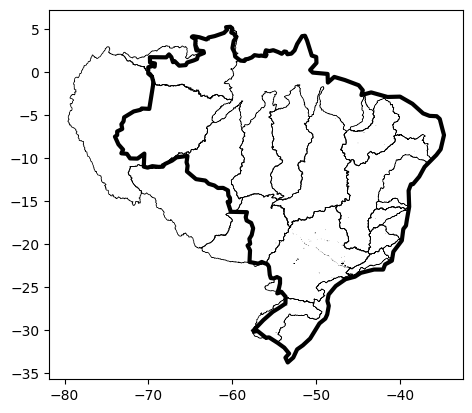

In [78]:
countries = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson')
br = countries.query("adm0_a3 == 'BRA'")
basins = gpd.read_file('/workspaces/bases/bacias de interesse SOE/bacias_interesse_ANA.shp')
ax = br.plot(facecolor='none', linewidth=3)
basins.plot(ax=ax, facecolor='none', linewidth=0.5)

(-35.7207944099458, 7.232371429045038)

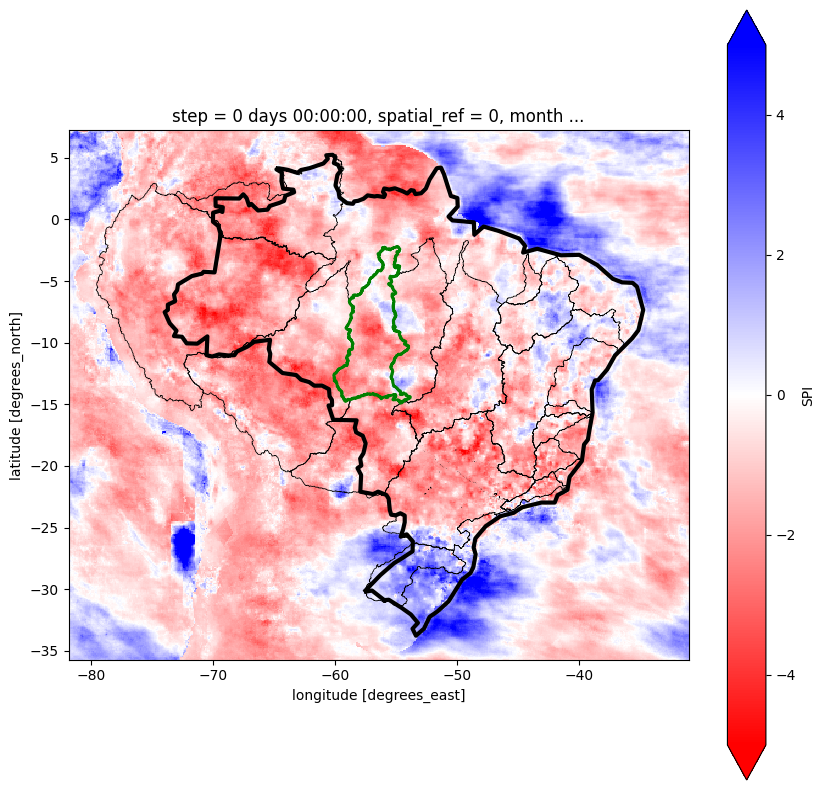

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))

br.plot(ax=ax, facecolor='none', linewidth=3, zorder=1)
basins.plot(ax=ax, facecolor='none', linewidth=0.5, zorder=1)
basins.loc[[9]].plot(ax=ax, facecolor='none', linewidth=2, edgecolor='green', zorder=2)

# Get the bounds of the plot
xmin, xmax, ymin, ymax = ax.axis()

spi.plot(cmap='bwr_r', ax=ax, zorder=0, vmax=5, vmin=-5)
ax.set_xlim(xmin, -31)
ax.set_ylim(ymin, ymax)

## 12 months animation

In [92]:
spi_cube = downloader.create_cube('2023-08', '2024-08', datatype=InpeTypes.MONTHLY_SPI, n=12)

In [93]:
spi_brasil = spi_cube.rio.clip(br['geometry'])

In [94]:
tapajos = basins.loc[[9]]
spi_tapajos = spi_cube.rio.clip(tapajos['geometry'])

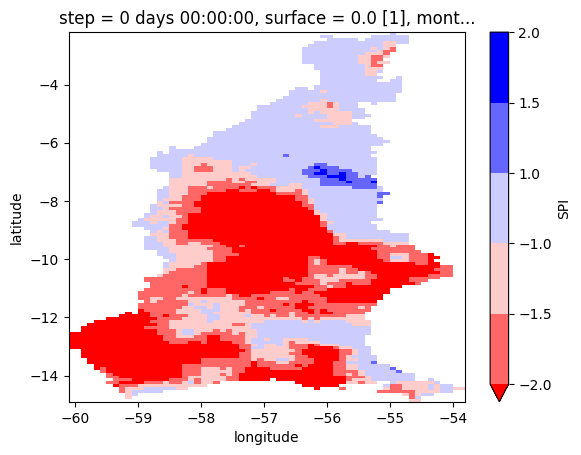

In [170]:
spi_tapajos.isel(time=-1).plot(cmap='bwr_r', vmin=-2, vmax=2, levels=[-2, -1.5, -1, 1, 1.5, 2])

In [114]:
import numpy as np

In [136]:
bins = np.arange(-3, 4)
bins, len(bins)

(array([-3, -2, -1,  0,  1,  2,  3]), 7)

In [134]:
categories = [f'D{i}' for i in range(len(bins))]
categories

['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6']

In [135]:
np.digitize(100, bins)

7

In [141]:
def categorize(x):
    idx = np.digitize(x, bins) - 1
    return bins[idx]

spi_brasil_cat = xr.apply_ufunc(categorize, spi_brasil.isel(time=-1), vectorize=True)

In [ ]:
spi_brasil.isnull

In [157]:
spi_brasil_cat = xr.where(spi_brasil<-1, -1, spi_brasil)
spi_brasil_cat = xr.where(spi_brasil<-1.5, -1.5, spi_brasil_cat)
spi_brasil_cat = xr.where(spi_brasil<-2, -2, spi_brasil_cat)


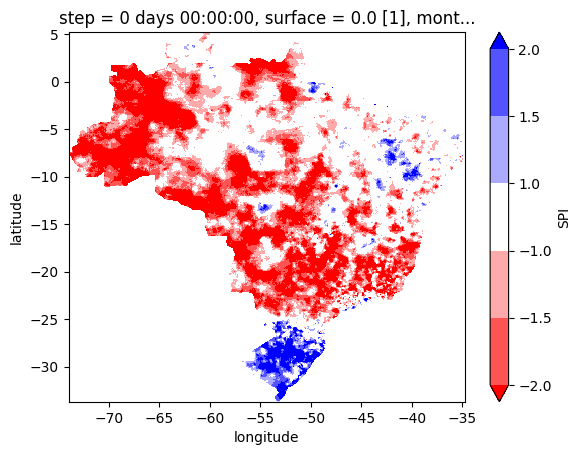

In [171]:
spi_brasil.isel(time=-1).plot(cmap='bwr_r', vmin=-2, vmax=2, levels=[-2, -1.5, -1, 1, 1.5, 2])

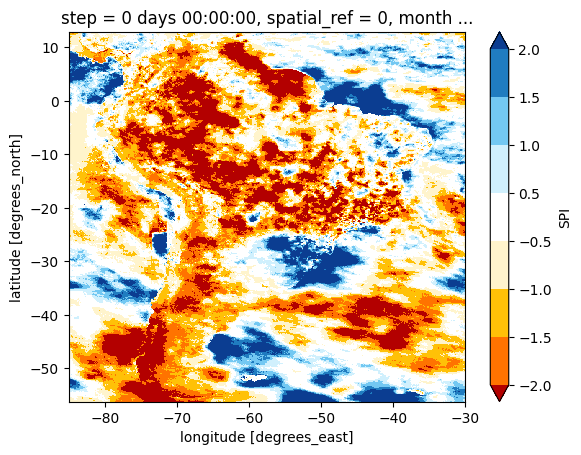

In [250]:
colors = ['#b30000', '#ff7300', '#ffc107', '#fff4cc', 'white', '#d0f0fd', '#73c8f2', '#207cc0', '#0b3d91']
spi.plot(levels=[-2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2], colors=colors)


In [102]:
spi_series = spi_tapajos.mean(dim=['latitude', 'longitude']).to_series()

(19551.7, 19954.3)

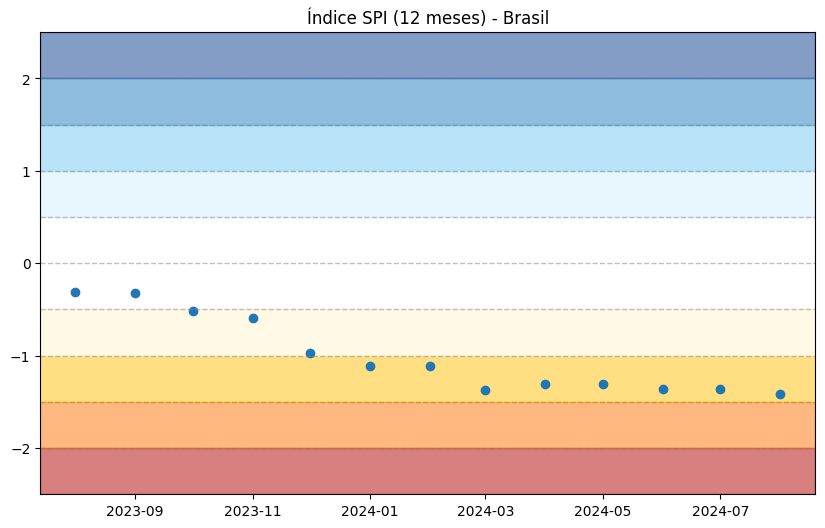

In [228]:
fig, ax = plt.subplots(figsize=(10, 6))

# draw thin and dashed fixed horizontal lines at y=0, y=-1 and y=1
for y in [-2, -1.5, -1., -0.5, 0, 0.5, 1., 1.5, 2]:
    ax.axhline(y, color='grey', alpha=0.5, linewidth=1, linestyle='dashed')

ax.scatter(spi_series.index, spi_series)

ax.set_title('Índice SPI (12 meses) - Brasil')
xmin, xmax, ymin, ymax = ax.axis()

ylims = [(2, 2.5), (1.5, 2), (1, 1.5), (0.5, 1)]
drought_colors = ['#fff4cc', '#ffc107', '#ff7300', '#b30000']
wet_colors = ['#d0f0fd', '#73c8f2', '#207cc0', '#0b3d91']
wet_colors.reverse()
drought_colors.reverse()

# plot the droughts limits
for ylim, color in zip(ylims, drought_colors):
    ax.fill_between([xmin, xmax], -ylim[0], -ylim[1], alpha=0.5, color=color, zorder=0)

for ylim, color in zip(ylims, wet_colors):
    ax.fill_between([xmin, xmax], ylim[0], ylim[1], alpha=0.5, color=color, zorder=0)

ax.set_ylim(-2.5, 2.5)
ax.set_xlim(xmin, xmax)

In [ ]:
anim.save('monthly_spi1_brasil.gif', writer='pillow', fps=1)

<Figure size 640x480 with 0 Axes>

In [251]:
def plot_spi1_map(ax: plt.Axes, itime: int, cube: xr.DataArray, shp: gpd.GeoDataFrame, vmax: float, vmin: float, add_colorbar: bool):
    shp.plot(ax=ax, facecolor='none', linewidth=3)
    xmin, xmax, ymin, ymax = ax.axis()

    colors = ['#b30000', '#ff7300', '#ffc107', '#fff4cc', 'white', '#d0f0fd', '#73c8f2', '#207cc0', '#0b3d91']
    levels=[-2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2]

    cube.isel(time=itime).plot.imshow(ax=ax, levels=levels, colors=colors, add_colorbar=add_colorbar)
    # cube.isel(time=itime).plot.imshow(ax=ax, cmap='bwr_r', vmax=vmax, vmin=vmin, add_colorbar=add_colorbar)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    date = DateProcessor.pretty_date(cube.time.values[itime].astype('str')[:10], "%Y-%m")
    ax.set_title(f'Índice SPI (12 meses)\n{date}')
    
def plot_spi1_chart(ax: plt.Axes, itime: int, cube: xr.DataArray, vmax: float, vmin: float):
    cube_series = cube.mean(dim=['latitude', 'longitude']).to_series()

    ax.scatter(cube_series.index, cube_series, color='black')

    ax.set_ylim(-3, 3)
    ax.set_title('Índice SPI (1 mês) - Brasil')

    for y in [-2, -1, 0, 1, 2]:
        ax.axhline(y, color='grey', alpha=0.5, linewidth=1, linestyle='dashed')   

    ax.axvline(cube_series.index[itime], color='red', alpha=0.2) 
    ax.scatter(cube_series.index[itime], cube_series.iloc[itime], color='red', s=55)

    xmin, xmax, ymin, ymax = ax.axis()

    ylims = [(2, 2.5), (1.5, 2), (1, 1.5), (0.5, 1)]
    drought_colors = ['#fff4cc', '#ffc107', '#ff7300', '#b30000']
    wet_colors = ['#d0f0fd', '#73c8f2', '#207cc0', '#0b3d91']
    wet_colors.reverse()
    drought_colors.reverse()

    # plot the droughts limits
    for ylim, color in zip(ylims, drought_colors):
        ax.fill_between([xmin, xmax], -ylim[0], -ylim[1], alpha=0.5, color=color, zorder=0)

    for ylim, color in zip(ylims, wet_colors):
        ax.fill_between([xmin, xmax], ylim[0], ylim[1], alpha=0.5, color=color, zorder=0)

    ax.set_ylim(-2.5, 2.5)
    ax.set_xlim(xmin, xmax)    

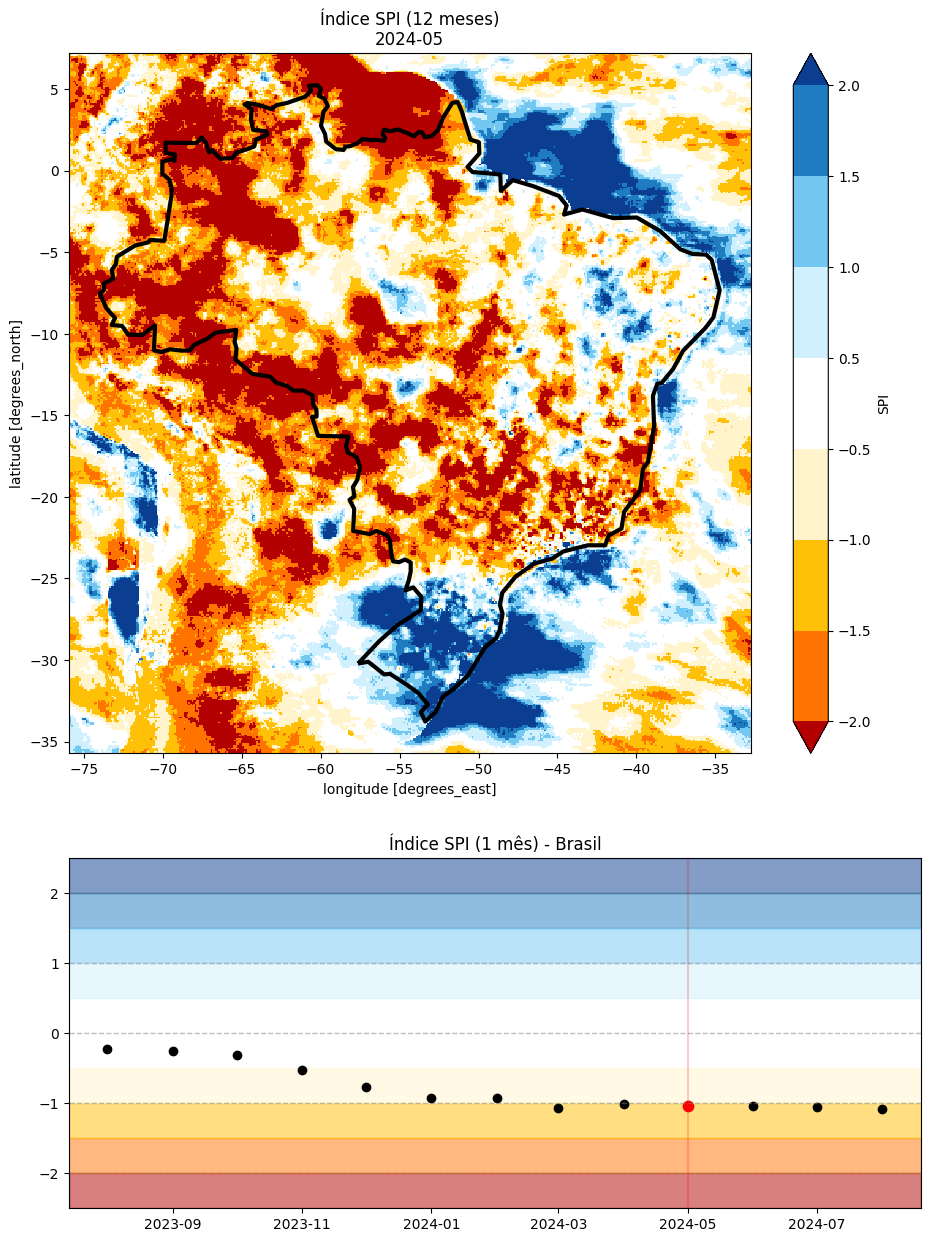

In [252]:
# create a figure with a 2x1 subplot, but the plots have distinct heights
fig = plt.figure(figsize=(11, 15))
gs = GridSpec(2, 1, figure=fig, height_ratios=[2, 1])
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

itime = 9
plot_spi1_map(
    ax=axs[0],
    itime=itime,
    cube=spi_cube,
    shp=br,
    vmax=3,
    vmin=-3,
    add_colorbar=True
)

plot_spi1_chart(
    ax=axs[1],
    itime=itime,
    cube=spi_brasil,
    vmax=3,
    vmin=-3
)

## Animation Loop

In [253]:
def update(frame):
    axs[0].clear()
    plot_spi1_map(axs[0], frame, spi_cube, br, 3, -3, False)

    axs[1].clear()
    plot_spi1_chart(axs[1], frame, spi_brasil, 3, -3)

    return axs[0].get_images()



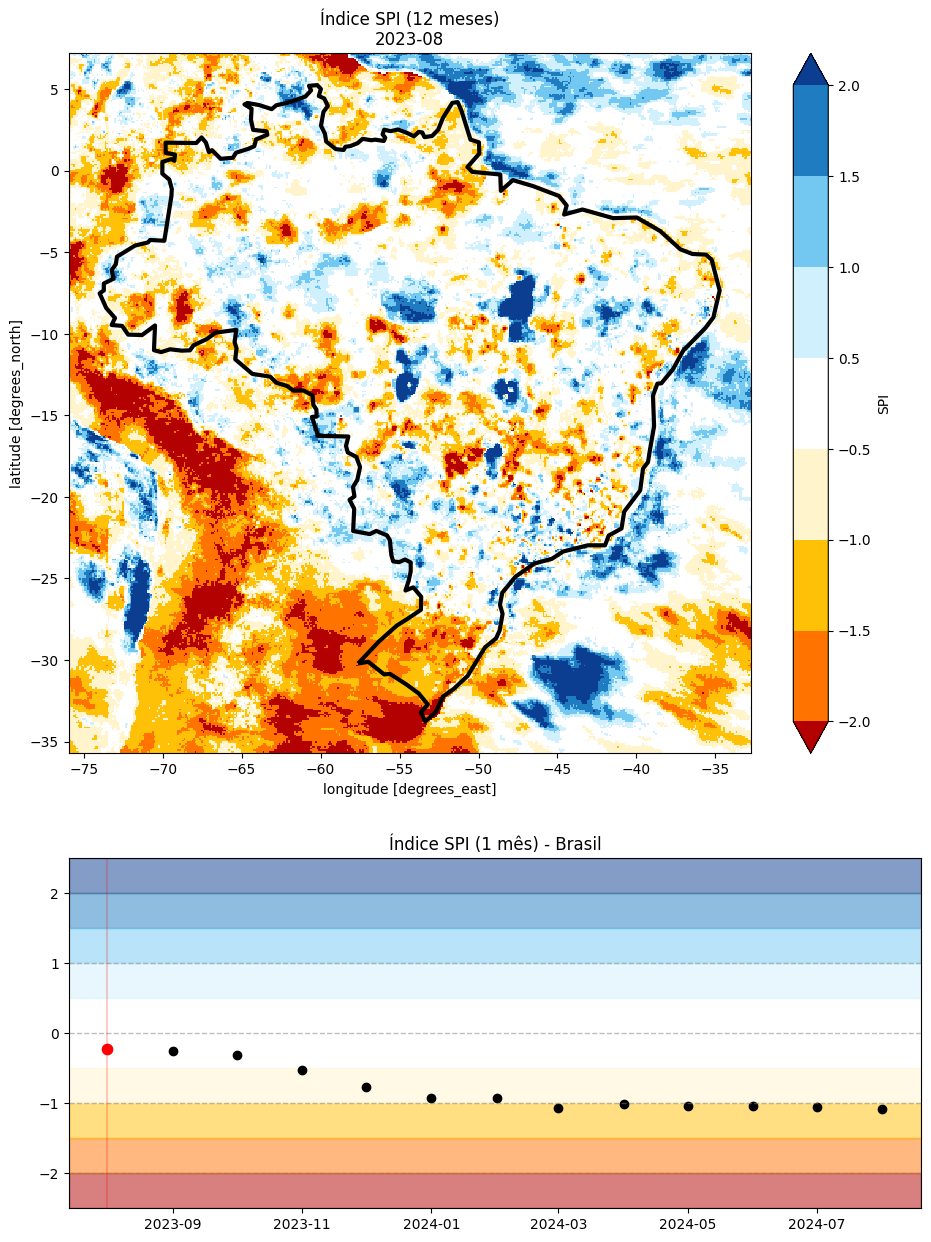

In [254]:
vmin=-3
vmax=3

# create a figure with a 2x1 subplot, but the plots have distinct heights
fig = plt.figure(figsize=(11, 15))
gs = GridSpec(2, 1, figure=fig, height_ratios=[2, 1])
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

# Draw first map
plot_spi1_map(axs[0], 0, spi_cube, br, vmax, vmin, True)
plot_spi1_chart(axs[1], 0, spi_brasil, vmax, vmin)

anim = FuncAnimation(fig, update, frames=len(spi_cube.time), blit=True)

In [255]:
anim.save('monthly_spi12_brasil.gif', writer='pillow', fps=1)

<Figure size 640x480 with 0 Axes>

## Animating a specific basin

<Axes: >

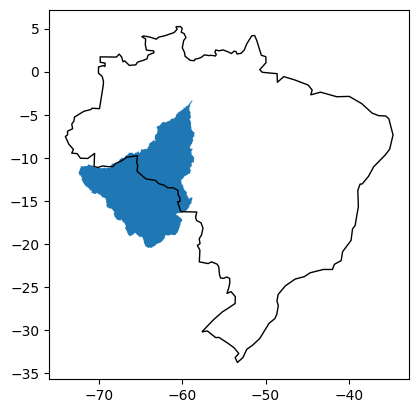

In [268]:
basin = basins.loc[[12]]
ax=basin.plot()
br.plot(ax=ax, facecolor='none')


In [269]:
spi_basin = spi_cube.rio.clip(basin['geometry'])

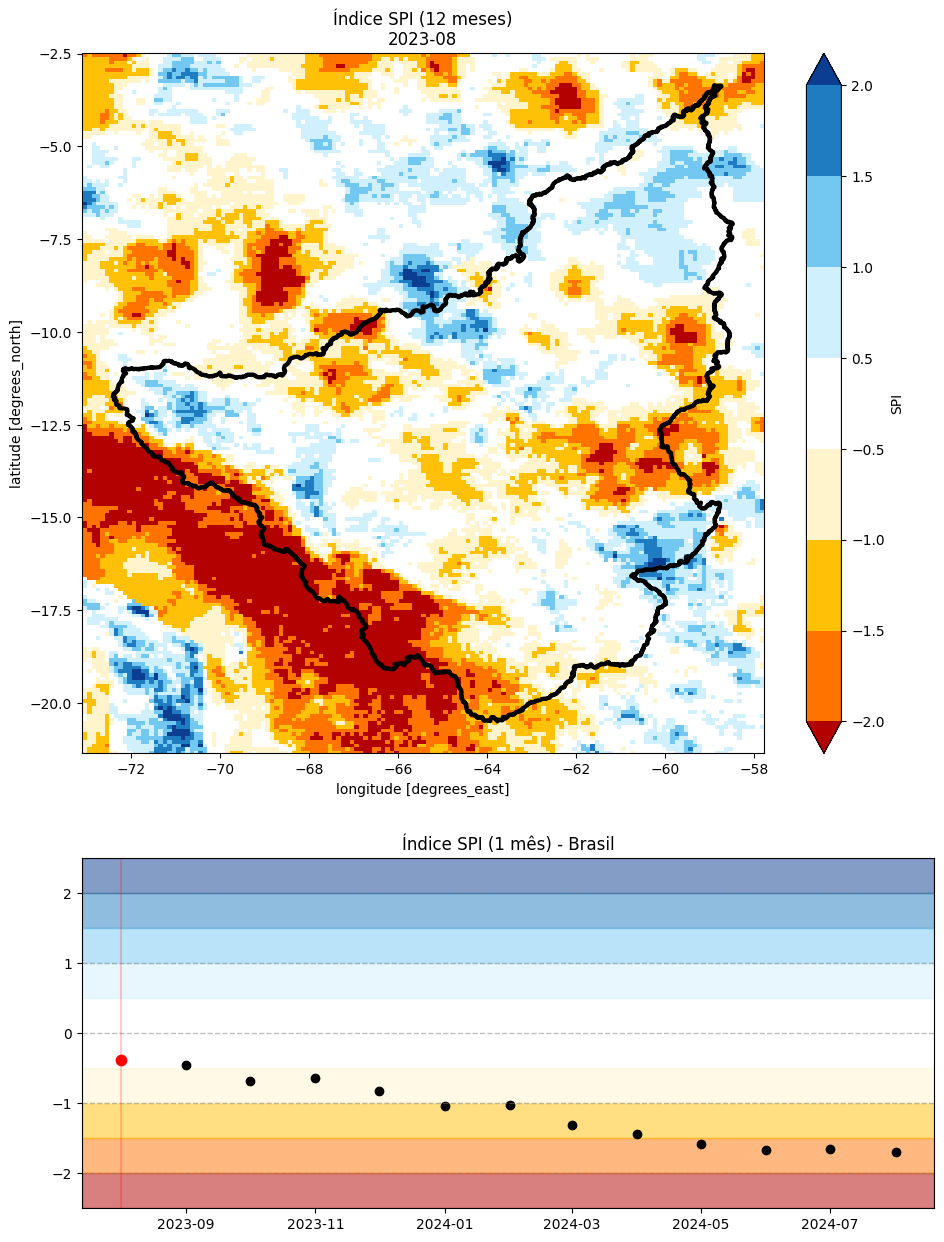

In [278]:
vmin=-3
vmax=3

def update(frame):
    axs[0].clear()
    plot_spi1_map(axs[0], frame, spi_cube, basin, 3, -3, False)

    axs[1].clear()
    plot_spi1_chart(axs[1], frame, spi_basin, 3, -3)

    return axs[0].get_images()


# create a figure with a 2x1 subplot, but the plots have distinct heights
fig = plt.figure(figsize=(11, 15))
gs = GridSpec(2, 1, figure=fig, height_ratios=[2, 1])
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

# Draw first map
plot_spi1_map(axs[0], 0, spi_cube, basin, vmax, vmin, True)
plot_spi1_chart(axs[1], 0, spi_basin, vmax, vmin)

anim = FuncAnimation(fig, update, frames=len(spi_cube.time), blit=True)

In [279]:
anim.save('monthly_spi12_madeira.gif', writer='pillow', fps=1)

<Figure size 640x480 with 0 Axes>

## Dev: `SPIProcessor` Class

In [28]:
## Testing the inform_dependencies from the MONTHLY_SPI parser
parser = InpeParsers[InpeTypes.MONTHLY_SPI]

In [59]:
dependencies = parser.inform_dependencies(DateProcessor.parse_date('2024-08'), n=3)
dependencies

{<InpeTypes.MONTHLY_AVG_N: 8>: [{'date': datetime.datetime(2024, 8, 27, 0, 0),
   'n': 3}],
 <InpeTypes.MONTHLY_STD_N: 9>: [{'date': datetime.datetime(2024, 8, 27, 0, 0),
   'n': 3}],
 <InpeTypes.MONTHLY_ACCUM_MANUAL: 5>: ['20240627', '20240727', '20240827']}

In [60]:
# Fill the dependencies
self = downloader
if dependencies is not None:
    filled = {}

    for dtype, lst in dependencies.items():
        filled[dtype] = self._parse_dependencies(datatype=dtype, lst=lst)
else:
    filled = None

In [61]:
avg = filled[InpeTypes.MONTHLY_AVG_N][0].squeeze()
std = filled[InpeTypes.MONTHLY_STD_N][0].squeeze()


In [62]:
rain = xr.concat(filled[InpeTypes.MONTHLY_ACCUM_MANUAL], dim='time')
rain = rain.mean(dim='time')

In [63]:
rain

<xarray.DataArray 'pacum' (latitude: 924, longitude: 1001)>
array([[26.354166  , 65.1875    , 64.208336  , ...,  6.8125    ,
         6.5416665 ,  7.0416665 ],
       [67.645836  , 66.666664  , 64.625     , ...,  5.8958335 ,
         6.0208335 ,  5.8333335 ],
       [68.041664  , 68.395836  , 65.708336  , ...,  5.875     ,
         6.0416665 ,  6.8125    ],
       ...,
       [ 0.22916667,  0.27083334,  0.08333334, ...,  1.0625    ,
         1.3125    ,  1.7708334 ],
       [ 0.1875    ,  0.29166666,  0.25      , ...,  0.875     ,
         0.8541667 ,  0.8541667 ],
       [ 0.125     ,  0.16666667,  0.16666667, ...,  0.7083333 ,
         0.7916667 ,  0.8125    ]], dtype=float32)
Coordinates:
    step         timedelta64[ns] 00:00:00
    surface      float64 2.55e+03
  * latitude     (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude    (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    spatial_ref  int64 0

In [64]:
rain = rain.rio.reproject_match(avg)

In [65]:
rain = rain.rename({"x": "longitude", "y": "latitude"})
rain

<xarray.DataArray 'pacum' (latitude: 691, longitude: 551)>
array([[ 88.479164,  89.270836,  89.208336, ...,  12.729167,  13.979167,
         13.645833],
       [ 86.520836,  85.604164,  86.      , ...,  11.75    ,  12.979167,
         14.0625  ],
       [ 83.6875  ,  84.5     ,  83.6875  , ...,  12.520833,  13.791667,
         14.      ],
       ...,
       [273.5     , 263.3125  , 254.85417 , ...,  74.958336,  69.145836,
         45.229168],
       [264.33334 , 264.75    , 262.75    , ...,  51.0625  ,  49.6875  ,
         43.583332],
       [274.54166 , 281.27084 , 276.35416 , ...,  45.354168,  44.854168,
         38.208332]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
    step         timedelta64[ns] 00:00:00
    surface      float64 2.55e+03
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

In [66]:
spi = (rain - avg) / std

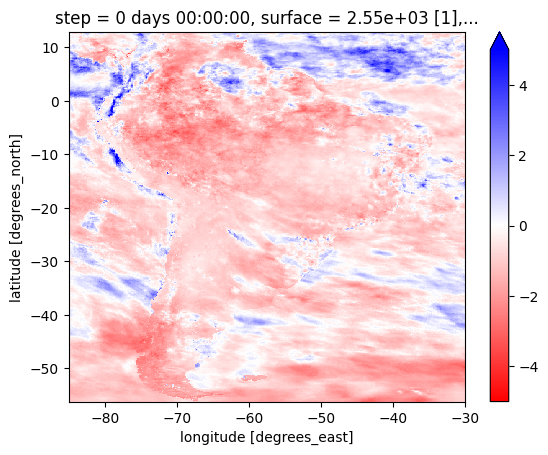

In [67]:
spi.plot(cmap='bwr_r', vmin=-5, vmax=5)

In [21]:
avg_parser = InpeParsers[InpeTypes.MONTHLY_AVG_N]
avg_parser.local_folder('2000-01', output_folder='/workspaces/reports_folder/downloads2/', n=3)

PosixPath('/workspaces/reports_folder/downloads2/MONTHLY_STATS_N/MONTHLY_STATS_3')

In [22]:
std_parser = downloader.get_parser('MONTHLY_STD_N')
std_parser.local_target('2000-01', output='/workspaces/reports_folder/downloads2/', n=1)

PosixPath('/workspaces/reports_folder/downloads2/MONTHLY_STATS_N/MONTHLY_STATS_1/Monthly_STD_jan_N1.nc')

If we try to grab a file and it does not exists, it should raise an exception, explaining how to calculate them... let's try it.

In [23]:
file = std_parser.local_target('2002-01', output='/workspaces/reports_folder/downloads2/', n=1)
if file.exists():
    file.unlink()

# downloader.get_file('2002-01', datatype=InpeTypes.MONTHLY_STD_N, n=1)

## `StatsCalculator` class

In [24]:
from mergedownloader.stats_calculator import StatsCalculator

# calculator = StatsCalculator(downloader)
# calculator.calc_monthly_avg_std_n(3)

In [25]:
arr = downloader.open_file('2023-02', datatype=InpeTypes.MONTHLY_AVG_N, n=3)

/usr/local/lib/python3.10/dist-packages/ecmwflibs/__init__.py:81: UserWarning: libglib-2.0.so.0: cannot open shared object file: No such file or directory
  warnings.warn(str(e))


In [26]:
arr

<xarray.DataArray 'avg_n' (time: 1, latitude: 691, longitude: 551)>
[380741 values with dtype=float64]
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
    spatial_ref  int64 ...
    month        int64 ...
  * time         (time) datetime64[ns] 2023-02-01

## Dev: Calculate AVERAGE and STD for N months timeframe 

In [14]:
# First thing we need to calculate the Monthly Average is to create a cube with the `MONTHLY_ACCUM_YEARLY` type.

# The calculation is done on a monthly basis, but, considering we have a moving window, it's easier to 
# grab the entire cube at once

# let's get all the available months into a cube
cube = downloader.create_cube('2000-01', '2023-12', datatype=InpeTypes.MONTHLY_ACCUM_YEARLY)


In [15]:
cube

<xarray.DataArray 'pacum' (time: 283, latitude: 691, longitude: 551)>
array([[[9.187500e+01, 9.275000e+01, 9.675000e+01, ..., 1.350000e+01,
         1.387500e+01, 1.325000e+01],
        [8.912500e+01, 9.587500e+01, 1.011250e+02, ..., 1.587500e+01,
         1.375000e+01, 1.375000e+01],
        [9.587500e+01, 1.000000e+02, 1.003750e+02, ..., 1.512500e+01,
         1.625000e+01, 1.400000e+01],
        ...,
        [2.205000e+02, 2.278750e+02, 2.053750e+02, ..., 6.000000e+00,
         6.250000e+00, 6.750000e+00],
        [1.958750e+02, 1.978750e+02, 2.135000e+02, ..., 8.875000e+00,
         1.062500e+01, 1.037500e+01],
        [1.932500e+02, 1.963750e+02, 2.075000e+02, ..., 1.125000e+01,
         1.325000e+01, 1.275000e+01]],

       [[2.102500e+02, 2.092500e+02, 2.097500e+02, ..., 1.375000e+01,
         1.512500e+01, 1.625000e+01],
        [2.203750e+02, 2.181250e+02, 2.201250e+02, ..., 1.450000e+01,
         1.562500e+01, 1.487500e+01],
        [2.220000e+02, 2.166250e+02, 2.147500e+02, ..., 1.650000e+01,
         1.525000e+01, 1.537500e+01],
...
        [1.953750e+02, 1.790000e+02, 2.038750e+02, ..., 4.500000e+00,
         5.250000e+00, 4.750000e+00],
        [1.896250e+02, 1.687500e+02, 1.898750e+02, ..., 4.625000e+00,
         4.000000e+00, 3.500000e+00],
        [1.743750e+02, 1.752500e+02, 1.728750e+02, ..., 3.875000e+00,
         4.000000e+00, 3.250000e+00]],

       [[1.560625e+02, 1.560625e+02, 1.515000e+02, ..., 1.603125e+02,
         1.541250e+02, 1.576250e+02],
        [1.524375e+02, 1.496875e+02, 1.443750e+02, ..., 1.477500e+02,
         1.460625e+02, 1.408750e+02],
        [1.492500e+02, 1.500000e+02, 1.423750e+02, ..., 1.440000e+02,
         1.426250e+02, 1.420000e+02],
        ...,
        [3.487500e+01, 3.575000e+01, 3.625000e+01, ..., 1.000000e+00,
         6.250000e-01, 6.875000e-01],
        [4.362500e+01, 4.725000e+01, 4.350000e+01, ..., 7.500000e-01,
         2.500000e-01, 6.250000e-01],
        [4.612500e+01, 5.600000e+01, 5.068750e+01, ..., 5.000000e-01,
         3.750000e-01, 6.250000e-01]]])
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
  * time         (time) datetime64[ns] 2000-06-01T12:00:00 ... 2023-12-01T12:...
    spatial_ref  int64 0

In [18]:
moving_average = cube.rolling(time=3).mean()

In [19]:
# remove the dates where we don't have the moving window calculated
moving_average = moving_average.dropna('time', how='all')

In [20]:
moving_average

<xarray.DataArray 'pacum' (time: 281, latitude: 691, longitude: 551)>
array([[[131.125     , 131.29166667, 131.04166667, ...,  14.25      ,
          14.66666667,  14.5       ],
        [132.20833333, 133.41666667, 136.08333333, ...,  14.58333333,
          14.        ,  13.41666667],
        [131.29166667, 133.04166667, 133.79166667, ...,  14.58333333,
          14.70833333,  13.875     ],
        ...,
        [202.33333333, 190.83333333, 181.375     , ..., 100.41666667,
         108.16666667, 111.875     ],
        [197.45833333, 194.29166667, 196.45833333, ...,  90.83333333,
         101.66666667, 117.83333333],
        [204.625     , 201.375     , 202.83333333, ..., 104.5       ,
         125.66666667, 139.16666667]],

       [[121.91666667, 121.25      , 120.29166667, ...,  22.54166667,
          24.08333333,  24.66666667],
        [121.91666667, 122.125     , 122.33333333, ...,  21.08333333,
          21.95833333,  21.33333333],
        [117.66666667, 120.08333333, 119.45833333, ...,  20.54166667,
          20.16666667,  20.04166667],
...
        [118.41666667, 114.5       , 121.45833333, ...,  63.66666667,
          64.66666667,  62.125     ],
        [121.75      , 111.04166667, 111.79166667, ...,  64.375     ,
          61.16666667,  59.41666667],
        [117.04166667, 114.79166667, 111.54166667, ...,  62.70833333,
          57.29166667,  55.45833333]],

       [[181.14583333, 183.10416667, 182.08333333, ..., 126.60416667,
         120.66666667, 118.41666667],
        [180.8125    , 181.64583333, 181.04166667, ..., 117.91666667,
         115.14583333, 113.29166667],
        [183.41666667, 181.75      , 182.91666667, ..., 115.91666667,
         115.33333333, 115.45833333],
        ...,
        [ 95.66666667,  92.375     ,  98.95833333, ...,  25.70833333,
          24.66666667,  23.6875    ],
        [ 96.70833333,  90.125     ,  97.20833333, ...,  23.25      ,
          21.79166667,  21.33333333],
        [ 92.75      ,  94.95833333,  95.97916667, ...,  21.66666667,
          21.25      ,  19.625     ]]])
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
  * time         (time) datetime64[ns] 2000-08-01T12:00:00 ... 2023-12-01T12:...
    spatial_ref  int64 0

In [23]:
grouped_avg = moving_average.groupby('time.month').mean('time')
grouped_std = moving_average.groupby('time.month').std('time')

In [25]:
grouped_avg.isel(month=1)

<xarray.DataArray 'pacum' (latitude: 691, longitude: 551)>
array([[154.06884058, 154.33333333, 154.87952899, ..., 126.70108696,
        128.47373188, 130.66847826],
       [153.66213768, 154.5       , 155.01630435, ..., 126.71376812,
        128.69021739, 130.20289855],
       [154.10597826, 154.48460145, 154.57065217, ..., 126.30887681,
        127.3451087 , 130.18206522],
       ...,
       [ 46.05253623,  45.44655797,  51.54121377, ...,  20.58967391,
         22.30525362,  22.17028986],
       [ 50.24003623,  52.72780797,  57.15398551, ...,  19.13949275,
         19.95289855,  20.2798913 ],
       [ 50.25362319,  55.76268116,  56.71376812, ...,  18.72735507,
         19.22554348,  19.83514493]])
Coordinates:
  * longitude    (longitude) float64 -85.05 -84.95 -84.85 ... -30.15 -30.05
  * latitude     (latitude) float64 -56.15 -56.05 -55.95 ... 12.65 12.75 12.85
    spatial_ref  int64 0
    month        int64 2